In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [17]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

In [2]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [3]:
dict_labels = {"awake" : 0, "light-propofol" : 1, "deep-propofol" : 2}
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = package.preprocessing.flatten_higher_triangular(fc_train)
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))
fc_test = torch.squeeze(fc_test,dim=2)
fc_test_vector = package.preprocessing.flatten_higher_triangular(fc_test)
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [4]:
dfc_train_light_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train_light_propofol = torch.from_numpy(dfc_train_light_propofol.reshape((dfc_train_light_propofol.shape[0],464,1,82,82)))
fc_train_light_propofol = torch.squeeze(fc_train_light_propofol,dim=2)
fc_train_light_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_train_light_propofol)

dfc_train_deep_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train_deep_propofol = torch.from_numpy(dfc_train_deep_propofol.reshape((dfc_train_deep_propofol.shape[0],464,1,82,82)))
fc_train_deep_propofol = torch.squeeze(fc_train_deep_propofol,dim=2)
fc_train_deep_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_train_deep_propofol)

dfc_test_light_propofol = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
fc_test_light_propofol = torch.from_numpy(dfc_test_light_propofol.reshape((dfc_test_light_propofol.shape[0],464,1,82,82)))
fc_test_light_propofol = torch.squeeze(fc_test_light_propofol,dim=2)
fc_test_light_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_test_light_propofol)

dfc_test_deep_propofol = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_test_deep_propofol = torch.from_numpy(dfc_test_deep_propofol.reshape((dfc_test_deep_propofol.shape[0],464,1,82,82)))
fc_test_deep_propofol = torch.squeeze(fc_test_deep_propofol,dim=2)
fc_test_deep_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_test_deep_propofol)

In [18]:
tab_light_propofol = package.preprocessing.stable_distance(fc_train_light_propofol,threshold = 0.7)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [19]:
tab_deep_propofol = package.preprocessing.stable_distance(fc_train_deep_propofol,threshold = 0.7)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


(array([6.900e+01, 1.770e+02, 7.005e+03, 2.178e+03, 7.500e+02, 1.950e+02,
        1.420e+02, 5.500e+01, 5.700e+01, 9.000e+00, 6.000e+00, 8.000e+00,
        5.000e+00, 8.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 1.        ,  3.45000005,  5.9000001 ,  8.35000038, 10.80000019,
        13.25      , 15.69999981, 18.14999962, 20.60000038, 23.04999924,
        25.5       , 27.95000076, 30.39999962, 32.84999847, 35.29999924,
        37.75      , 40.20000076, 42.65000153, 45.09999847, 47.54999924,
        50.        ]),
 <BarContainer object of 20 artists>)

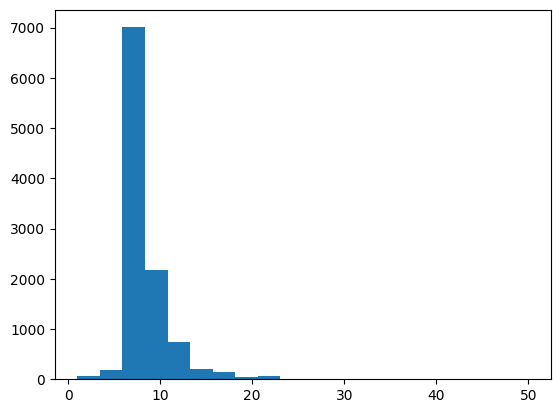

In [23]:
plt.hist(tab_light_propofol.flatten(),bins=20)

(array([6.600e+01, 1.505e+03, 6.820e+03, 1.294e+03, 4.190e+02, 5.900e+01,
        1.800e+01, 1.300e+01, 8.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 1.        ,  3.70000005,  6.4000001 ,  9.10000038, 11.80000019,
        14.5       , 17.20000076, 19.89999962, 22.60000038, 25.29999924,
        28.        , 30.70000076, 33.40000153, 36.09999847, 38.79999924,
        41.5       , 44.20000076, 46.90000153, 49.59999847, 52.29999924,
        55.        ]),
 <BarContainer object of 20 artists>)

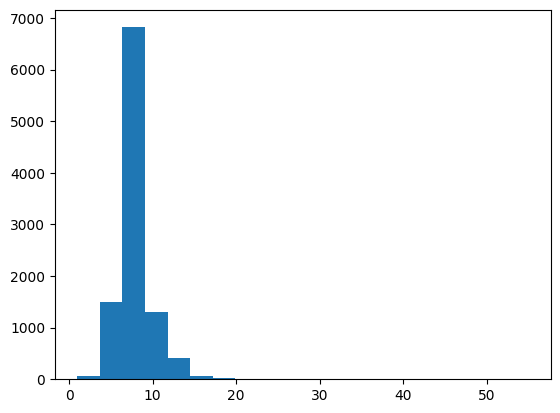

In [22]:
plt.hist(tab_deep_propofol.flatten(),bins=20)

In [29]:
meta[(meta["monkey"] == "jade") & (meta["condition"] == "deep-propofol")]

,monkey,run,session,condition,matlab_kmeans_labels,unique_id
37584,jade,run10,20120302,deep-propofol,3,20120302_run10
37585,jade,run10,20120302,deep-propofol,3,20120302_run10
37586,jade,run10,20120302,deep-propofol,3,20120302_run10
37587,jade,run10,20120302,deep-propofol,3,20120302_run10
37588,jade,run10,20120302,deep-propofol,3,20120302_run10
...,...,...,...,...,...,...
41291,jade,run5,20120413,deep-propofol,3,20120413_run5
41292,jade,run5,20120413,deep-propofol,3,20120413_run5
41293,jade,run5,20120413,deep-propofol,3,20120413_run5
41294,jade,run5,20120413,deep-propofol,3,20120413_run5


In [32]:
labels_session = np.array([meta["condition"].iloc[i*464] for i in range(len(meta)//464)])
labels_monkey = np.array([meta["monkey"].iloc[i*464] for i in range(len(meta)//464)])

In [34]:
np.argwhere((labels_session == "light-propofol") & (labels_monkey == "jade") )

array([[56],
       [57]])

In [33]:
np.argwhere((labels_session == "deep-propofol") & (labels_monkey == "jade") )

array([[81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88]])

In [41]:
fc_test_deep_propofol_vector.shape

(8, 464, 3321)

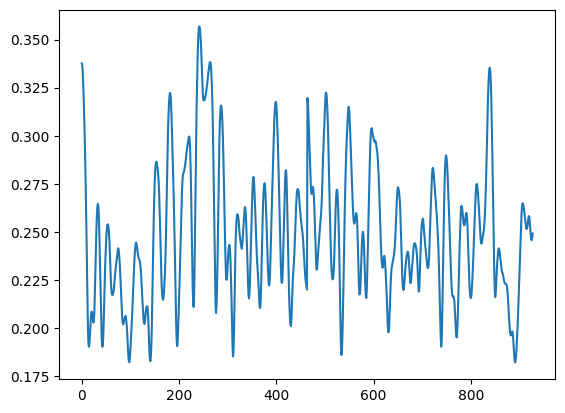

In [49]:
plt.plot(np.mean(np.abs(fc_test_light_propofol_vector),axis = 2).flatten())

In [50]:
def structure_score(img):
    return np.transpose(img) @ img

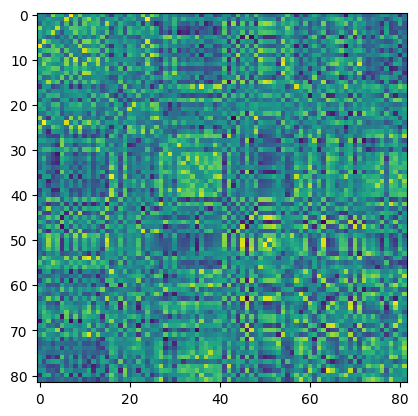

In [93]:
plt.imshow(fc_test_deep_propofol[1,10,:,:])

In [102]:
tab_struct_score_deep_propofol = np.zeros((fc_test_deep_propofol.shape[0],fc_test_deep_propofol.shape[1]))
for i in range(fc_test_deep_propofol.shape[0]):
    for j in range(fc_test_deep_propofol.shape[1]):
        mat = structure_score(np.abs(fc_test_deep_propofol[i,j,:,:]))
        tab_struct_score_deep_propofol[i,j] = np.mean(mat.numpy())

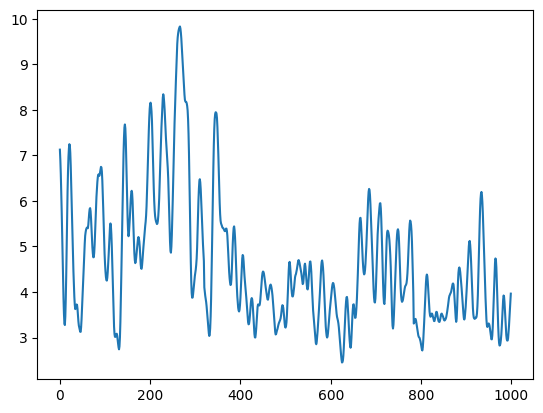

In [144]:
plt.plot(tab_struct_score_deep_propofol.flatten()[2000:3000])

In [104]:
tab_struct_score_light_propofol = np.zeros((fc_test_light_propofol.shape[0],fc_test_light_propofol.shape[1]))
for i in range(fc_test_light_propofol.shape[0]):
    for j in range(fc_test_light_propofol.shape[1]):
        mat = structure_score(np.abs(fc_test_light_propofol[i,j,:,:]))
        tab_struct_score_light_propofol[i,j] = np.mean(mat.numpy())

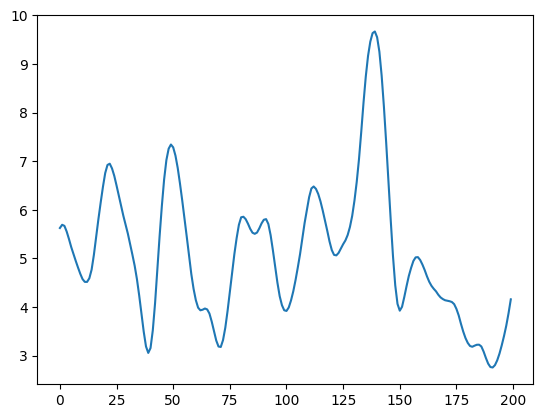

In [112]:
plt.plot(tab_struct_score_light_propofol.flatten()[700:900])

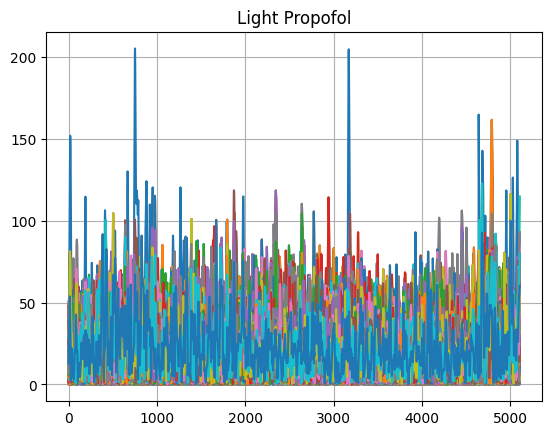

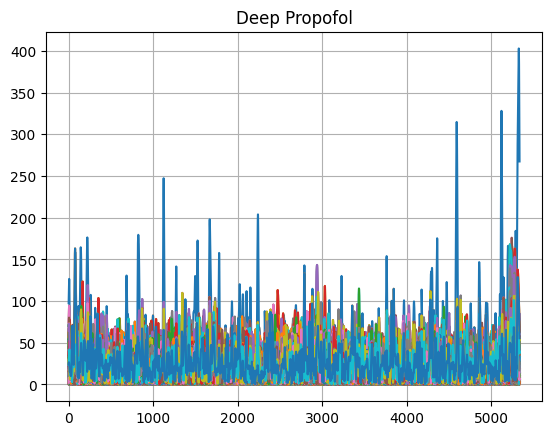

In [143]:
from scipy.fft import fft, fftfreq
# Number of sample points

a,b,c = fc_train_deep_propofol_vector.shape
y = fc_train_deep_propofol_vector.reshape((a*b,c))
yf = fft(y)
plt.plot(np.abs(yf)[:len(yf)//2])
plt.grid()
plt.title("Light Propofol")
plt.show()

d,e,f = fc_train_light_propofol_vector.shape
z = fc_train_light_propofol_vector.reshape((d*e,f))
zf = fft(z)
plt.plot(np.abs(zf)[:len(zf)//2])
plt.grid()
plt.title("Deep Propofol")
plt.show() 